# Data scraping awesome public datasets

This is a companion notebook for the new [Data Science Solutions](https://strtupsci.com) book. The code is explained in the book.

In [235]:
%matplotlib inline
import urllib2
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from subprocess import check_output
plt.style.use('seaborn-pastel')
# plt.style.available

In [236]:
awesome_list = 'https://github.com/caesar0301/awesome-public-datasets/blob/master/README.rst'
html = urllib2.urlopen(awesome_list)
scrape = BeautifulSoup(html, 'lxml')

In [237]:
category_name_feature = []; about_feature = []
name_feature = []; vintage_feature = []
link_feature = []; category_id_feature = []
github_feature = []; dataset_feature = []

In [238]:
# Populate github column
def extract_github_feature(link_text, link_url):
    if link_text:
        github_ref = link_url.find('github.com')

        if github_ref > -1:
            github_feature.append('Yes')
        else:
            github_feature.append('No')            
    else:
        github_feature.append('No')

In [239]:
# Populate dataset column
def extract_dataset_feature(link_text, link_url):
    if link_text:
        dataset_ref = link_url.find('dataset')
        datasource_ref = link_url.find('datasets')

        if dataset_ref > -1 and datasource_ref == -1:
            dataset_feature.append('Yes')
            return

        if dataset_ref > -1 and datasource_ref > -1:
            dataset_feature.append('No')
            return

        if dataset_ref == -1:
            dataset_feature.append('No')
            return
    else:
        dataset_feature.append('No')

In [240]:
# Populate vintage column
def extract_vintage_feature(link_text):
    if link_text:
        twenty = link_text.find('20')
        nineteen = link_text.find('19')
        if twenty > -1:
            if all(char.isdigit() for char in link_text[twenty:twenty+4]):
                vintage_feature.append(link_text[twenty:twenty+4])
            else:
                vintage_feature.append('NA')
            return
        if nineteen > -1:
            if all(char.isdigit() for char in link_text[nineteen:nineteen+4]):
                vintage_feature.append(link_text[nineteen:nineteen+4])
            else:
                vintage_feature.append('NA')        
            return
        vintage_feature.append('NA')
    else:
        vintage_feature.append('NA')

In [241]:
# Populate name column
def extract_name_feature(link_text):
    shortname = None
    if link_text:
        # Prefix to hyphen is a short name
        split_dash = link_text.find(' - ')
        if split_dash > -1:
            shortname = link_text[0:split_dash]

        # Abbreviations in brackets are short names
        split_brackets = link_text.find('(')
        end_brackets = link_text.find(')')
        if split_brackets > -1:
            shortname = link_text[split_brackets + 1:end_brackets]

    if shortname:
        if all(char.isdigit() for char in shortname):
            shortname = None
                
    if shortname:
        name_feature.append(shortname)
    else:
        if link_text:
            # First four words are a short name
            dataset_words = link_text.split()
            if len(dataset_words) > 2:
                name_feature.append(' '.join(dataset_words[0:2]))
            else:
                name_feature.append(link_text)
        else:
            name_feature.append(None)

In [242]:
headings_list = scrape.find_all('h2')
for heading in headings_list:
    if heading.a:
        category = heading.a.next_sibling.string
        category_name_feature.append(category)
        link_list = heading.next_sibling.next_sibling.find_all('li')
        for link in link_list:
            link_text = link.string
            category_id_feature.append(category)
            about_feature.append(link_text)
            link_url = link.a.get('href')
            link_feature.append(link_url)
            
            extract_github_feature(link_text, link_url)
            extract_dataset_feature(link_text, link_url)
            extract_vintage_feature(link_text)
            extract_name_feature(link_text)

In [243]:
df = pd.DataFrame(
    {'name': name_feature, 'about': about_feature, 
     'link': link_feature, 'vintage': vintage_feature,
     'dataset': pd.Categorical(dataset_feature),
     'category_id': pd.Categorical(category_id_feature),
     'github': pd.Categorical(github_feature)})

df = df.loc[:, ['name', 'about', 'link', 'category_id', 
                'dataset', 'github', 'vintage']]
df.head()

,name,about,link,category_id,dataset,github,vintage
0,U.S. Department,U.S. Department of Agriculture's PLANTS Database,http://www.plants.usda.gov/dl_all.html,Agriculture,No,No,NA
1,1000 Genomes,1000 Genomes,http://www.1000genomes.org/data,Biology,No,No,NA
2,Microbiome Project,American Gut (Microbiome Project),https://github.com/biocore/American-Gut,Biology,No,Yes,NA
3,CCLE,Broad Cancer Cell Line Encyclopedia (CCLE),http://www.broadinstitute.org/ccle/home,Biology,No,No,NA
4,BBBC,Broad Bioimage Benchmark Collection (BBBC),https://www.broadinstitute.org/bbbc,Biology,No,No,NA


In [244]:
df_categories = pd.DataFrame({'name': category_name_feature})
df_categories.head()

,name
0,Agriculture
1,Biology
2,Climate/Weather
3,Complex Networks
4,Computer Networks


In [245]:
df.describe()

,name,about,link,category_id,dataset,github,vintage
count,395,395,414,414,414,414,414
unique,393,395,412,31,2,2,15
top,Medicare Data,RevolutionAnalytics Collection,http://law.di.unimi.it/datasets.php,Biology,No,No,NA
freq,2,1,3,42,407,394,389


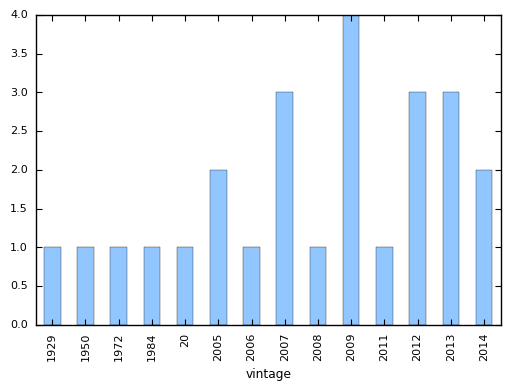

In [246]:
df[df.vintage!='NA'].groupby('vintage').count().dataset.plot.bar()

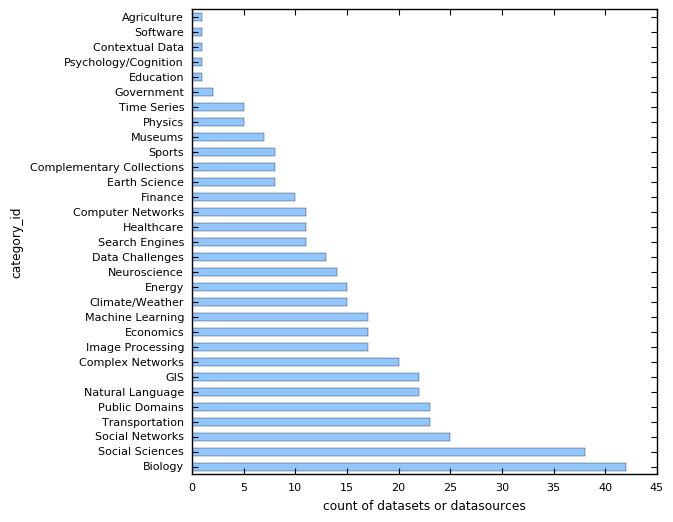

In [251]:
sorted_by_category_count = df.groupby(
    'category_id').count().sort_values(
    by='dataset', ascending=False)

plt.figure(figsize = (6,6))
plt.xlabel('count of datasets or datasources')
sorted_by_category_count.dataset.plot.barh(stacked=True)

In [252]:
df_datasources = df[
    (df.dataset=='No') 
    & (df.github=='No') 
    & (df.vintage=='NA')]
df_datasources.describe()

,name,about,link,category_id,dataset,github,vintage
count,348,348,367,367,367,367,367
unique,346,348,366,31,1,1,1
top,Medicare Data,RevolutionAnalytics Collection,http://law.di.unimi.it/datasets.php,Biology,No,No,NA
freq,2,1,2,40,367,367,367


In [253]:
df_datasets = df[
    (df.dataset=='Yes') 
    | (df.github=='Yes') 
    | (df.vintage!='NA')]
df_datasets.describe()

,name,about,link,category_id,dataset,github,vintage
count,47,47,47,47,47,47,47
unique,47,47,47,16,2,2,15
top,Open Traffic,"Ergast Formula 1, from 1950 up to date (API)",http://ops.fhwa.dot.gov/freight/freight_analys...,Transportation,No,No,NA
freq,1,1,1,9,40,27,22


In [250]:
df_categories.to_csv(
    'data/scraping/categories.csv', 
    index=False)
df_datasets.to_csv(
    'data/scraping/datasets.csv', 
    na_rep='BLANK', index=False)
df_datasources.to_csv(
    'data/scraping/datasources.csv', 
    na_rep='BLANK', index=False)

print(check_output(["ls", "data/scraping"]).decode("utf8"))

categories.csv
datasets.csv
datasources.csv

